<a href="https://colab.research.google.com/github/ShubhamVermaDev9/BreastCancerClassifiicatiuon/blob/main/Anemia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Early Detection of Pernicious Anemia Risk**

In [2]:
!pip install xgboost shap scikit-learn pandas matplotlib seaborn

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)

from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# **Data Loading**

In [4]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])
df.head()

Saving TEST 2.csv to TEST 2.csv


,id,age,weight,height,sex,stress,doctor,sport,pernicious_1,pernicious_2,ubp,lbp
0,5,51.712526,85.0,154,1,1,1,1.0,0.0,0.0,130,80
1,6,52.134155,69.0,170,2,1,1,1.0,NaN,0.0,130,90
2,7,55.939767,70.0,160,1,1,1,0.0,0.0,0.0,120,75
3,10,49.645448,94.0,185,2,1,1,1.0,NaN,0.0,130,90
4,11,44.060233,76.0,170,2,1,1,1.0,0.0,0.0,120,80


# **EDA**

In [5]:
print("Dataset Shape:", df.shape)
df.info()

Dataset Shape: (30000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            30000 non-null  int64  
 1   age           30000 non-null  float64
 2   weight        30000 non-null  float64
 3   height        30000 non-null  int64  
 4   sex           30000 non-null  int64  
 5   stress        30000 non-null  int64  
 6   doctor        30000 non-null  int64  
 7   sport         27103 non-null  float64
 8   pernicious_1  26970 non-null  float64
 9   pernicious_2  26969 non-null  float64
 10  ubp           30000 non-null  int64  
 11  lbp           30000 non-null  int64  
dtypes: float64(5), int64(7)
memory usage: 2.7 MB


In [6]:
df.isnull().sum()

,0
id,0
age,0
weight,0
height,0
sex,0
stress,0
doctor,0
sport,2897
pernicious_1,3030
pernicious_2,3031


# **Target Variable Selection**

In [7]:
TARGET = "pernicious_1"

X = df.drop(columns=[TARGET])
y = df[TARGET]

# **Missing Value Treatment**

In [8]:
X = X.fillna(X.median())

# **Train–Test Split**

In [9]:
# Identify and remove rows with NaN values in the target variable 'y'
nan_indices_in_y = y[y.isnull()].index
X_cleaned = X.drop(index=nan_indices_in_y)
y_cleaned = y.drop(index=nan_indices_in_y)

X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned,
    test_size=0.2,
    random_state=42,
    stratify=y_cleaned
)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Selection & Training  # XGBoost Classifier **bold text** bold text **bold text**

In [11]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

# **Model Evaluation**

In [12]:
y_pred = xgb_model.predict(X_test_scaled)
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_prob))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy : 0.9171301446051168
Precision: 0.5985401459854015
Recall   : 0.1729957805907173
F1 Score : 0.2684124386252046
ROC AUC  : 0.8297326849850779

Classification Report:

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      4920
         1.0       0.60      0.17      0.27       474

    accuracy                           0.92      5394
   macro avg       0.76      0.58      0.61      5394
weighted avg       0.90      0.92      0.90      5394



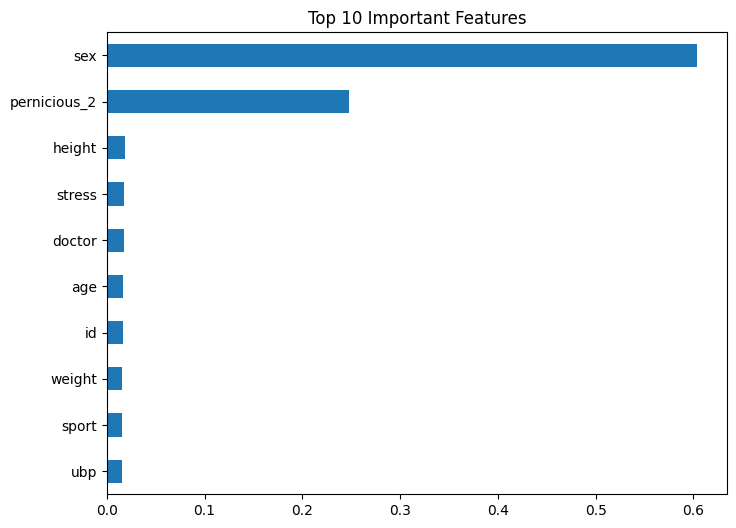

In [13]:
importances = xgb_model.feature_importances_
features = X.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_imp.head(10).plot(kind="barh")
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()

 99%|===================| 5343/5394 [01:24<00:00]       

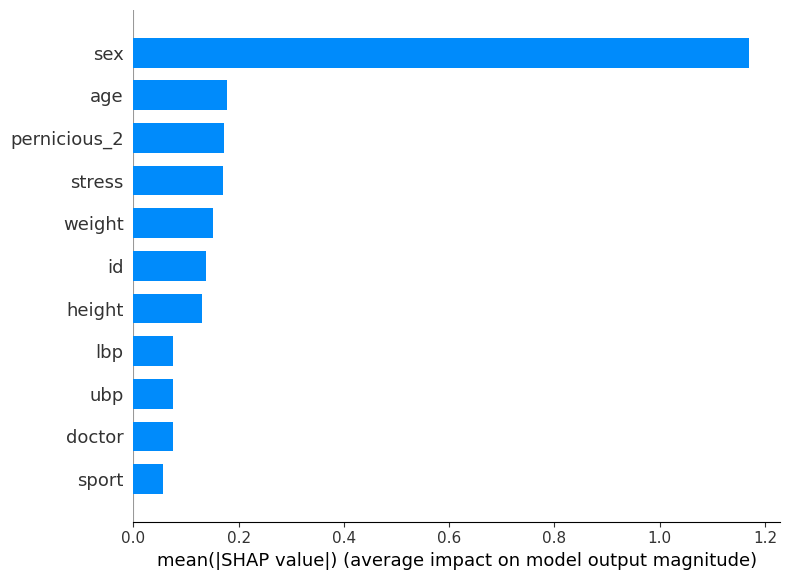

In [14]:
explainer = shap.Explainer(xgb_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test, plot_type="bar")

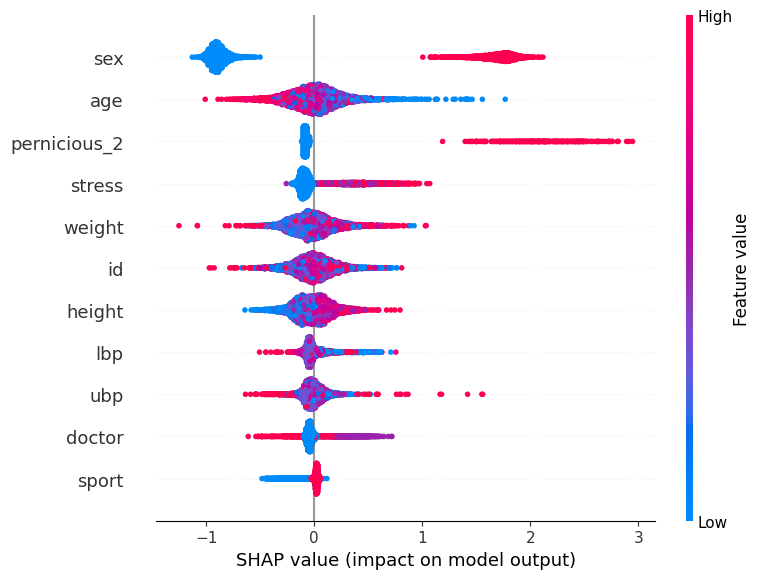

In [15]:
shap.summary_plot(shap_values, X_test)

# ** Model Saving**

In [16]:
import joblib
joblib.dump(xgb_model, "disease_xgboost_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

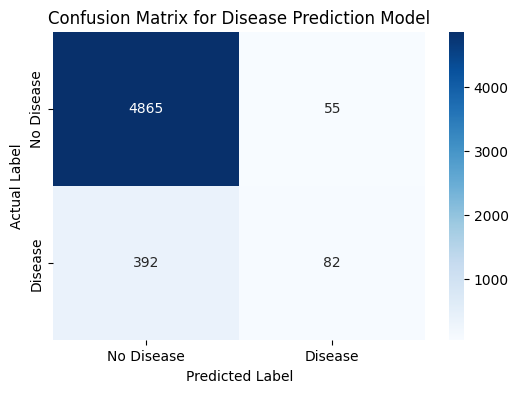

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Disease", "Disease"],
    yticklabels=["No Disease", "Disease"]
)

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Disease Prediction Model")
plt.show()